In [73]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

# Local import 

from spectra.py_spectra import *

# Two levels that are used to create mean analysis

analysis_levels  = [6,17,28]

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])


# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#-----------------------------------------------------------------
def run_spectral_analysis(in_dir, out_dir, day, nam = False):

    hrrr_dir  = str(os.path.join(in_dir, day, "hrrr"))
    rrfs0_dir = str(os.path.join(in_dir, day, "ctrl"))
    rrfs1_dir = str(os.path.join(in_dir, day, "nord3"))
    
    if nam == True:
        print("NAM analysis requested, will be added\n")
        nam_dir = str(os.path.join(in_dir, day, "nam"))

    # Open data sets

    hrrr  = open_mfdataset_list(hrrr_dir , "region_*.nc")
    rrfs0 = open_mfdataset_list(rrfs0_dir, "region_*.nc")
    rrfs1 = open_mfdataset_list(rrfs1_dir, "region_*.nc")
    
    if nam == True:
        nam = open_mfdataset_list(nam_dir, "region_*.nc")

    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these five levels are averaged together

        klevels = [k-2, k-1, k, k+1, k+2]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u = np.nan_to_num(hrrr.U.isel(nz=klevels).values).astype('float64')
        hrrr_v = np.nan_to_num(hrrr.V.isel(nz=klevels).values).astype('float64')
        hrrr_w = np.nan_to_num(hrrr.W.isel(nz=klevels).values).astype('float64')

        hrrr_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)


        rrfs0_u = np.nan_to_num(rrfs0.U.isel(nz=klevels).values).astype('float64')
        rrfs0_v = np.nan_to_num(rrfs0.V.isel(nz=klevels).values).astype('float64')
        rrfs0_w = np.nan_to_num(rrfs0.W.isel(nz=klevels).values).astype('float64')

        rrfs0_tk2 = 0.5*(rrfs0_u**2 + rrfs0_v**2)

        rrfs1_u = np.nan_to_num(rrfs1.U.isel(nz=klevels).values).astype('float64')
        rrfs1_v = np.nan_to_num(rrfs1.V.isel(nz=klevels).values).astype('float64')
        rrfs1_w = np.nan_to_num(rrfs1.W.isel(nz=klevels).values).astype('float64')

        rrfs1_tk2 = 0.5*(rrfs1_u**2 + rrfs1_v**2)
        
        if nam == True:

            nam_u = np.nan_to_num(nam.U.isel(nz=klevels).values).astype('float64')
            nam_v = np.nan_to_num(nam.V.isel(nz=klevels).values).astype('float64')
            nam_w = np.nan_to_num(nam.W.isel(nz=klevels).values).astype('float64')

            nam_tk2 = 0.5*(hrrr_u**2 + hrrr_v**2)

        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        ylim = [0.01,1.0e4]
        axis = 0
        func = get_spectra2D_POWSPEC

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs0_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=ylim, LinsborgSlope=True)
        plot_spectra(rrfs1_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim)
        
        if nam == True:
            plot_spectra(nam_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='green', ylim=ylim)
            plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red\nNAM:green', ptitle = 'W Pow_Spec', ylim=ylim)
        else:
            plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'W Pow_Spec', ylim=ylim)
            
        ax1 = fig.add_subplot(gs[0, 1])
        ylim = [1000.,1.0e10]

        plot_spectra(rrfs0_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='b', ylim=ylim, LinsborgSlope=True)
        plot_spectra(rrfs1_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim)

        if nam == True:
            plot_spectra(nam_tk2, func=func, axis=axis, ax=[ax1], legend='', PScolor='green', ylim=ylim)
            plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red\nNAM:green', ptitle = 'W Pow_Spec', ylim=ylim)
        else:
            plot_spectra(hrrr_tk2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nCTRL:blue\nNORD3:red', ptitle = 'Hor. TKE Pow_Spec', ylim=ylim)

        plt.suptitle("W-Spectra Avg Over all Case Days \n Pressure Level: %d hPa" % (plevels[k]/100), fontsize=20)

        plt.savefig("%s/spectra_%s_%3.3dhPa.png" % ('/work/wicker/CAM_analysis_tools', 'W-Spectra', plevels[k]/100),bbox_inches='tight', dpi=300)


Running day:  2021052612

NAM analysis requested, will be added


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_s

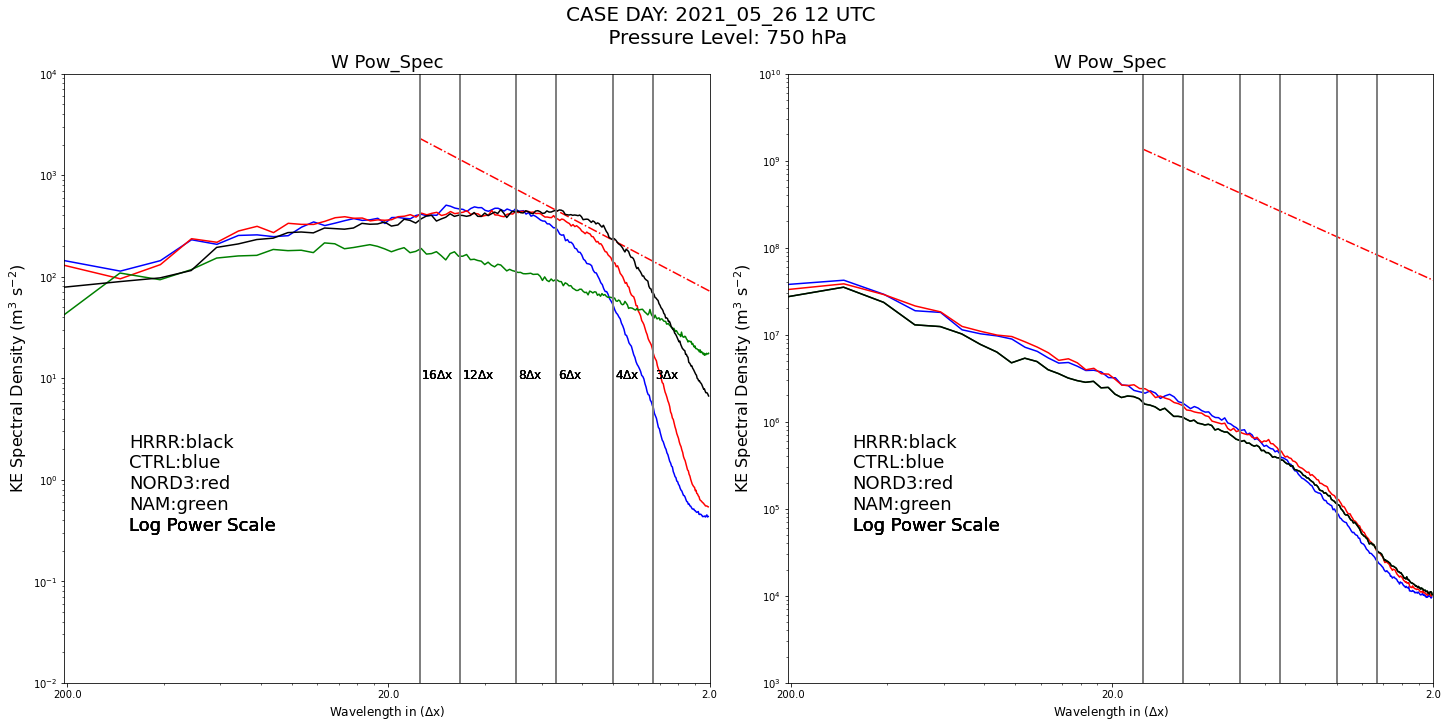


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped 

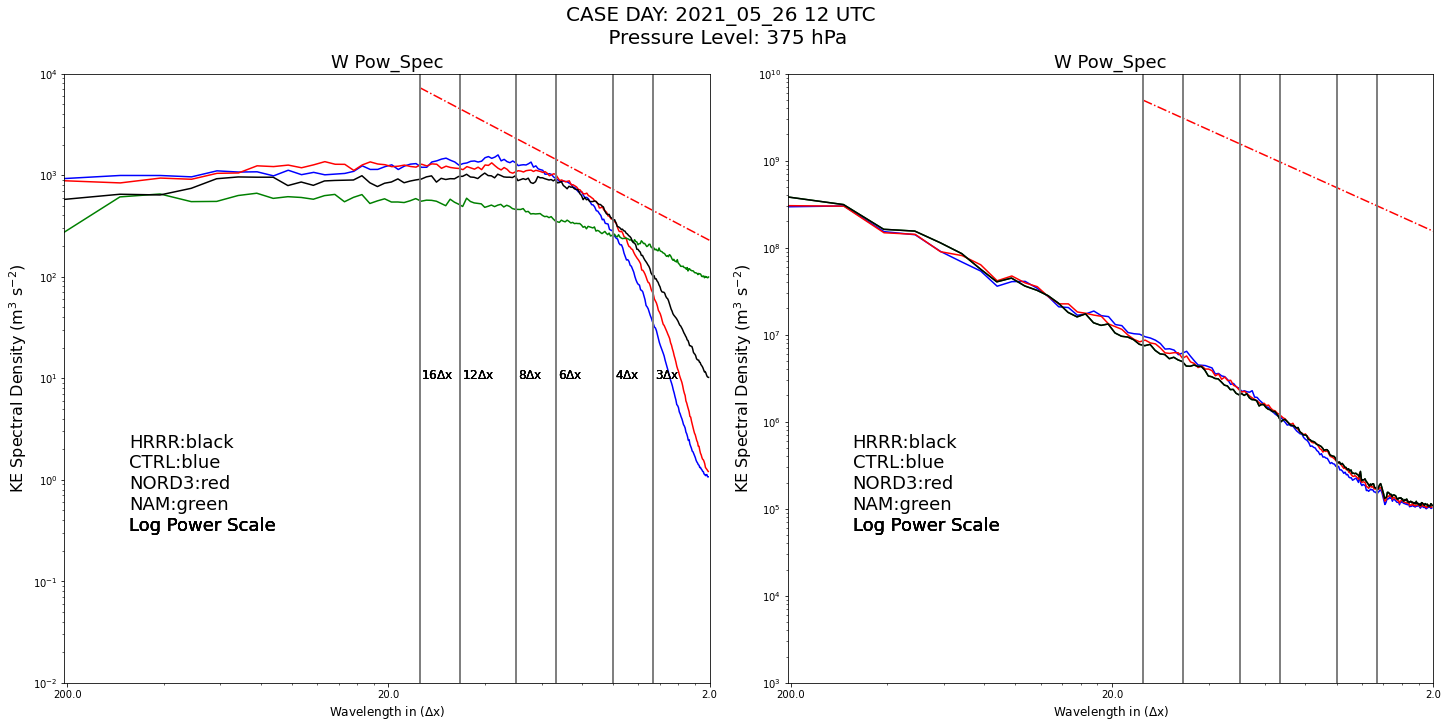

In [ ]:
in_dir  = "/work/larissa.reames"
out_dir = "/work/wicker/CAM_case_studies"
day     = ["2021052612"]

for d in day:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d, nam=True)


====> Begin processing runs


----> Processing run: hrrr for day:  2020081006 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: ctrl for day:  2020081006 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: nord3 for day:  2020081006 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: nam for day:  2020081006 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 30


----> Processing run: hrrr for day:  2020070700 


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spe

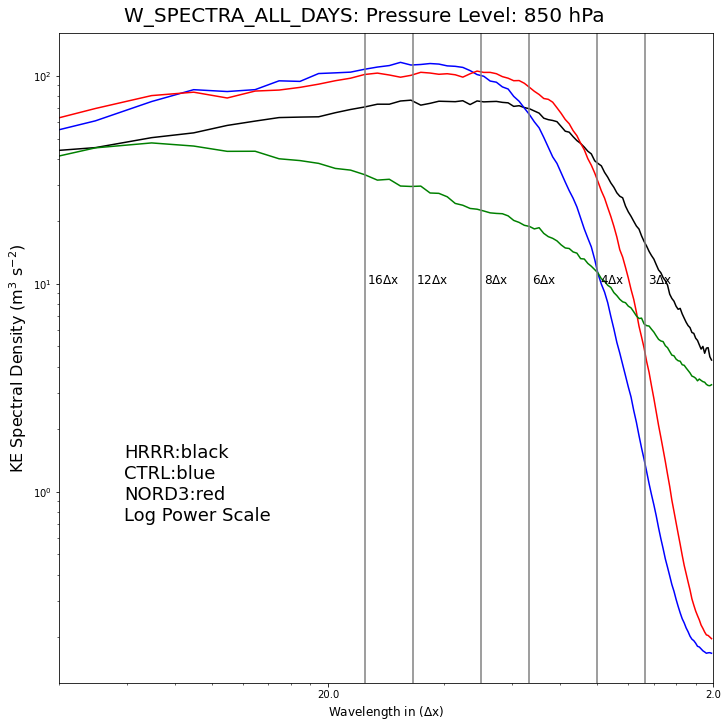

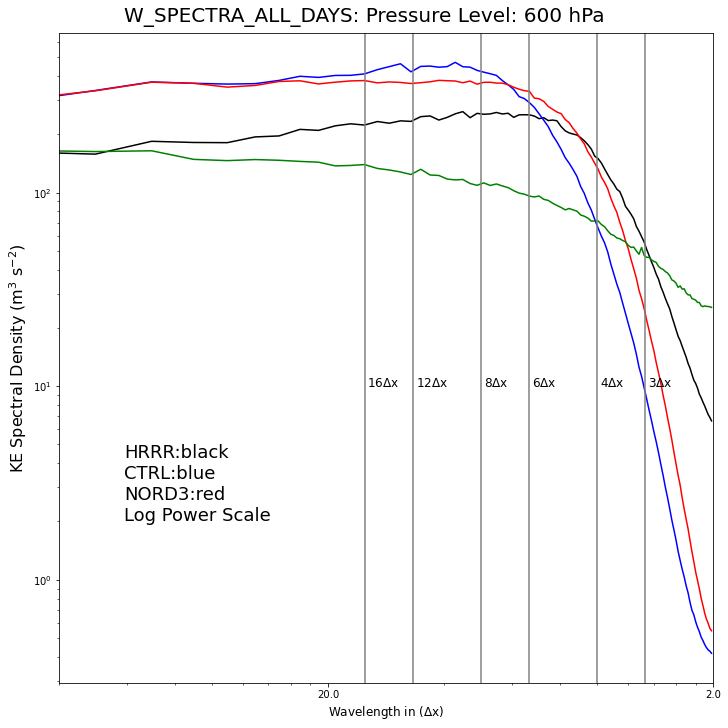

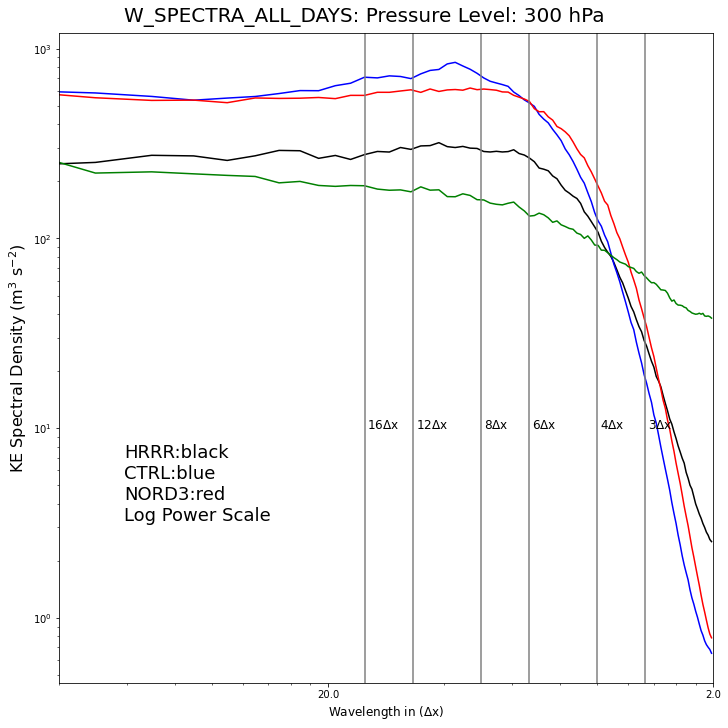

In [85]:
# Input data sets....

from input_default import input_test as input_config
import matplotlib.ticker as mticker

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

input_dir  = input_config["input_dir"]
output_dir = input_config["output_dir"]
ncases     = len(input_config["cases"])

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"hrrr":[], 
             "ctrl":[],
             "nam":[],
             "nord3":[]}

avg_data = {"hrrr" :np.zeros((ncases,avg_grid.shape[0],)), 
            "ctrl" :np.zeros((ncases,avg_grid.shape[0],)),
            "nam"  :np.zeros((ncases,avg_grid.shape[0],)),
            "nord3":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_POWSPEC
axis = None

#------------------------------------------------------------------------------------
# cut and past from below here
#

print("\n====> Begin processing runs\n")

analysis_levels  = [6,16,28]

for k in analysis_levels:
    for n,day in enumerate(input_config["cases"]):
        for run in input_config["cases"][day]:

            print("\n----> Processing run: %s for day:  %s \n" % (run,day))
            run_dir = str(os.path.join(input_dir, day, run))
            out_dir = str(os.path.join(output_dir, day, run))

            # Open data set

            data = open_mfdataset_list(run_dir , "region_*.nc")
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-2, k-1, k, k+1, k+2]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_w = np.nan_to_num(data.W.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = plot_spectra(data_w, ret_Data=True, no_Plot=True)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

#        plt.suptitle("RUN: %s  CASE DAY: %s_%s_%s %s UTC \n Pressure Level: %d hPa" % (run, day[0:4],day[4:6],day[6:8],day[8:10],data.pres[k]/100), fontsize=20)

# Now post the runs....

    legend='HRRR:black\nCTRL:blue\nNORD3:red'
    ptitle = 'W Power Spectrum'

    avg_hrrr  = avg_data['hrrr'].mean(axis=0)
    avg_ctrl  = avg_data['ctrl'].mean(axis=0)
    avg_nord3 = avg_data['nord3'].mean(axis=0)
    avg_nam   = avg_data['nam'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    axes.loglog(avg_grid, avg_hrrr,  color='black')
    axes.loglog(avg_grid, avg_ctrl,  color='blue')
    axes.loglog(avg_grid, avg_nord3, color='red')
    axes.loglog(avg_grid, avg_nam, color='green')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s\nLog Power Scale" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [0.01,1.0e3]

    ylabel = 10

    xoffset = [0.01, 0.0075, 0.005, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([3.0, 4.0, 6.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=12)
    axes.set_ylabel(r"KE Spectral Density (m$^3$ s$^{-2}$)", fontsize=16)

    # plt.title(ptitle, fontsize=18)

    plt.suptitle("W_SPECTRA_ALL_DAYS: Pressure Level: %d hPa" % (plevels[k]/100), fontsize=20)

    plt.savefig("%s/spectra_%s_%3.3dhPa.png" % ('/work/wicker/CAM_analysis_tools', 'W_ALL', plevels[k]/100),bbox_inches='tight',dpi=300)

